# Classifying Observed AIA Data with Timelags and Emission Measure Slopes
Classify observed timelags with a Random Forest classifier using timelag and emission measure data

In [74]:
import os
import sys

import numpy as np
from scipy.interpolate import splev,splrep,splprep,interp1d
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import astropy.units as u
from astropy.visualization import ImageNormalize,AsinhStretch,SqrtStretch
from astropy.coordinates import SkyCoord
from sunpy.map import Map,GenericMap
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.util import get_keys

sys.path.append('/Users/willbarnes/Documents/work/projects/synthesized_timelag_maps/scripts/')
from idl_colormaps import bgry_004_idl_cmap

%matplotlib inline

In [7]:
columnwidth = 2544.81458 #document width of my poster

In [8]:
def get_figsize(wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - cwidth [float]: width of the column in latex. Get this from LaTeX 
                             using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return (fig_width, fig_height)

In [3]:
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [4]:
heating = ['high_frequency','intermediate_frequency','low_frequency','cooling','cooling_outofphase_long',
           'observed']

In [9]:
titles = ['High','Intermediate','Low','Cooling','Random','Observed']

In [5]:
timelag_maps_root_path = '/Users/willbarnes/Downloads/shine2018_temp/{heating}_{c0}-{c1}_{type}.fits'

## Load Timelags

In [6]:
# Load in all timelag and correlation maps
timelags,correlations = {},{}
for h in heating:
    timelags[h],correlations[h] = {},{}
    for c0,c1 in channel_pairs:
        timelags[h][f'{c0}_{c1}'] = Map(timelag_maps_root_path.format(heating=h,type='timelag',c0=c0,c1=c1))
        correlations[h][f'{c0}_{c1}'] = Map(timelag_maps_root_path.format(heating=h,type='correlation',c0=c0,c1=c1))

## Plot Selected Timelags

In [13]:
selected_pairs = [(94,335),(335,171),(211,131)]

In [14]:
correlation_cutoff = 500.0

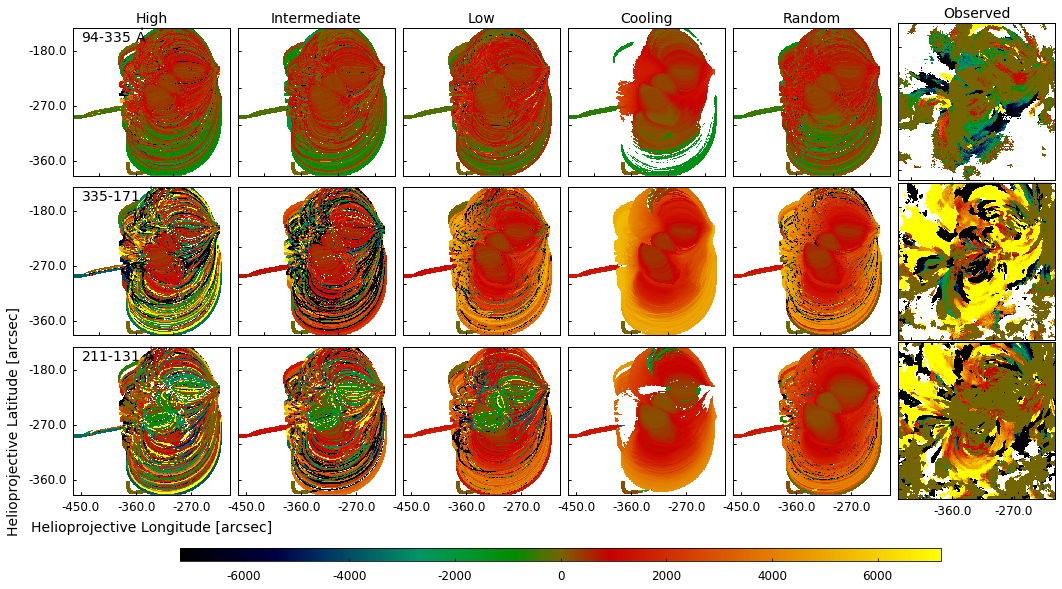

In [97]:
fig = plt.figure(figsize=get_figsize(wf=0.5,hf=0.5))
cax = fig.add_axes([0.21, 0.03, 0.6, 0.02])
map_plot_kwargs = {'cmap':bgry_004_idl_cmap,'vmin':(-2*u.hour).to(u.s).value,'vmax':(2*u.hour).to(u.s).value,
                   'annotate':False,'title':False}
for i,(c0,c1) in enumerate(selected_pairs):
    for j,h in enumerate(heating):
        tmp = timelags[h][f'{c0}_{c1}']
        tmp = tmp.submap(tmp.bottom_left_coord, SkyCoord(tmp.top_right_coord.Tx - 70*u.arcsec,
                                                         tmp.top_right_coord.Ty - 70*u.arcsec,
                                                         frame=tmp.coordinate_frame))
        tmp_cor = correlations[h][f'{c0}_{c1}']
        tmp_cor = tmp_cor.submap(tmp_cor.bottom_left_coord, SkyCoord(tmp_cor.top_right_coord.Tx - 70*u.arcsec,
                                                                     tmp_cor.top_right_coord.Ty - 70*u.arcsec,
                                                                     frame=tmp_cor.coordinate_frame))
        data = np.where((tmp_cor.data) < correlation_cutoff, np.nan, tmp.data)
        tmp = Map(data, tmp.meta)
        ax = fig.add_subplot(len(selected_pairs),6,6*i+j+1,projection=tmp)
        im = tmp.plot(axes=ax,**map_plot_kwargs)
        lon,lat = ax.coords
        lon.grid(draw_grid=False)
        lat.grid(draw_grid=False)
        if j==0 and i==len(selected_pairs)-1:
            lat.set_axislabel('Helioprojective Latitude [arcsec]',fontsize=plt.rcParams['axes.labelsize'])
            lon.set_axislabel('Helioprojective Longitude [arcsec]',fontsize=plt.rcParams['axes.labelsize'])
        if j==0:
            lat.set_ticks(number=3)
            lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
            xtext,ytext = tmp.world_to_pixel(SkyCoord(-450*u.arcsec, -165*u.arcsec, frame=tmp.coordinate_frame))
            ax.text(xtext.value,ytext.value,f'{c0}-{c1} $\mathrm{{\mathring{{A}}}}$',color='k',
                    fontsize=plt.rcParams['axes.labelsize'])
        else:
            lat.set_ticklabel_visible(False)
        if i<len(selected_pairs)-1:
            lon.set_ticklabel_visible(False)
        else:
            lon.set_ticks(number=3)
            lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
        if i==0:
            ax.set_title(titles[j],fontsize=plt.rcParams['axes.labelsize'])
cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
plt.subplots_adjust(hspace=0.0,wspace=0.05)
fig.savefig('../figures/timelag_maps.pdf')

## Classifier

In [25]:
X = None
Y = None
for i,f in enumerate(heating[:-3]):
    X_tmp = None
    # Find the indices where all channel pairs have an acceptable correlation
    acceptable = np.all(np.stack([correlations[f]['{}_{}'.format(*p)].data for p in channel_pairs], axis=2) 
                        > correlation_cutoff,axis=2)
    i_accept = np.where(acceptable)
    for p in channel_pairs:
        # Read in timelags and correlations
        tmp_tl = timelags[f]['{}_{}'.format(*p)].data
        # Only keep those timelags with sufficiently high correlations
        tmp_tl = tmp_tl[i_accept].flatten()
        # Stack along columns for different channel pairs
        X_tmp = tmp_tl.copy()[:,np.newaxis] if X_tmp is None else np.hstack([X_tmp, tmp_tl[:, np.newaxis]])
    # Stack along rows for different frequencies
    X = X_tmp.copy() if X is None else np.vstack([X, X_tmp])
    Y_tmp = np.array(X_tmp.shape[0]*[titles[i]])
    Y = Y_tmp.copy() if Y is None else np.concatenate([Y, Y_tmp])
# Numerically encode frequency
le = LabelEncoder()
le.fit(['High','Intermediate','Low'])
Y_encoded = le.transform(Y)
# Scale data
X_scaled = scale(X, axis=0, with_mean=True, with_std=True,)
# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.33)

In [26]:
# Find the indices where all channel pairs have an acceptable correlation
acceptable_correlation = np.all(np.stack([correlations['observed']['{}_{}'.format(*p)].data
                                          for p in channel_pairs], axis=2) > correlation_cutoff,axis=2)
i_accept_obs = np.where(acceptable_correlation)
# Stack maps
X_observation = None
for p in channel_pairs:
    # Read in timelags and correlations
    tmp_tl = timelags['observed']['{}_{}'.format(*p)].data
    # Only keep those timelags with sufficiently high correlations
    tmp_tl = tmp_tl[i_accept_obs].flatten()
    # Stack along columns for different channel pairs
    X_observation = tmp_tl.copy()[:,np.newaxis] if X_observation is None else np.hstack([X_observation, tmp_tl[:, np.newaxis]])
# Scale data
X_observation = scale(X_observation, axis=0, with_mean=True, with_std=True)

In [27]:
clf = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=25,bootstrap=True,)

In [28]:
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
print(f'Test error = {1. - clf.score(X_test,Y_test)}')

Test error = 0.04426659432085367


In [30]:
Y_observation = clf.predict(X_observation)

In [31]:
Y_observation_prob = clf.predict_proba(X_observation)

In [32]:
probability_maps = {}
for i,f in enumerate(heating[:-3]):
    tmp = np.nan*timelags['observed']['{}_{}'.format(*channel_pairs[0])].data
    tmp[i_accept_obs] = Y_observation_prob[:,i]
    tmp = Map(tmp, timelags['observed']['{}_{}'.format(*channel_pairs[0])].meta)
    tmp = tmp.submap(tmp.bottom_left_coord,SkyCoord(tmp.top_right_coord.Tx - 70*u.arcsec,
                                                    tmp.top_right_coord.Ty - 70*u.arcsec,frame=tmp.coordinate_frame))
    probability_maps[f] = tmp

In [33]:
tmp = np.nan*timelags['observed']['{}_{}'.format(*channel_pairs[0])].data
tmp[i_accept_obs] = Y_observation
frequency_map = Map(tmp, timelags['observed']['{}_{}'.format(*channel_pairs[0])].meta)
frequency_map = frequency_map.submap(
    frequency_map.bottom_left_coord,
    SkyCoord(frequency_map.top_right_coord.Tx - 70*u.arcsec,
             frequency_map.top_right_coord.Ty - 70*u.arcsec,frame=frequency_map.coordinate_frame)
)

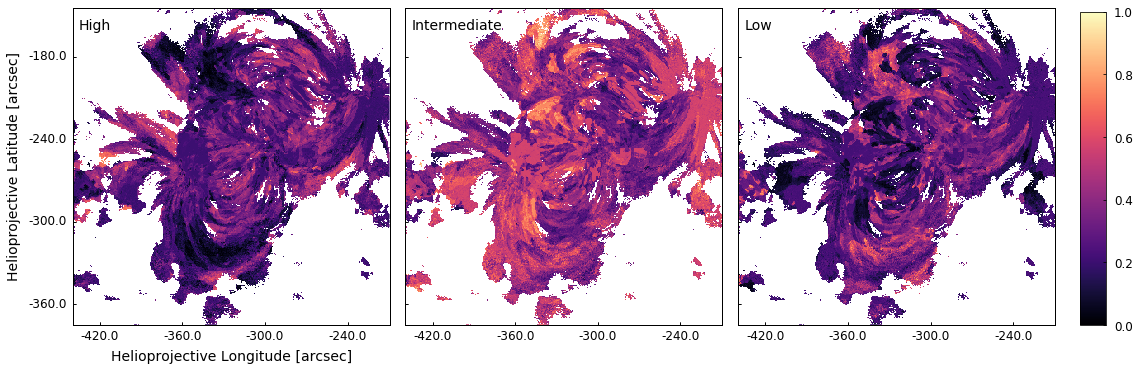

In [127]:
fig = plt.figure(figsize=get_figsize(wf=0.5,))
cax = fig.add_axes((0.92,0.3,0.02,0.4))
p_args = {'annotate':False,'vmin':0,'vmax':1,'cmap':'magma'}
# Probability maps
## High
ax = fig.add_subplot(1,3,1,projection=probability_maps['high_frequency'])
probability_maps['high_frequency'].plot(axes=ax,**p_args,title='High')
lon,lat = ax.coords[0],ax.coords[1]
lon.set_axislabel('Helioprojective Longitude [arcsec]',fontsize=plt.rcParams['axes.labelsize'])
lat.set_axislabel('Helioprojective Latitude [arcsec]',fontsize=plt.rcParams['axes.labelsize'])
lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
ax.grid(alpha=0)
xtext,ytext = probability_maps['high_frequency'].world_to_pixel(
    SkyCoord(-435*u.arcsec,-160*u.arcsec,frame=probability_maps['high_frequency'].coordinate_frame))
xtext,ytext = int(xtext.value),int(ytext.value)
ax.text(xtext,ytext,'High',color='k',fontsize=plt.rcParams['axes.labelsize'])
## Intermediate
ax = fig.add_subplot(1,3,2,projection=probability_maps['intermediate_frequency'])
probability_maps['intermediate_frequency'].plot(axes=ax,**p_args,title='Intermediate')
lon,lat = ax.coords[0],ax.coords[1]
lat.set_ticklabel_visible(False)
lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
ax.grid(alpha=0)
xtext,ytext = probability_maps['intermediate_frequency'].world_to_pixel(
    SkyCoord(-435*u.arcsec,-160*u.arcsec,frame=probability_maps['intermediate_frequency'].coordinate_frame))
xtext,ytext = int(xtext.value),int(ytext.value)
ax.text(xtext,ytext,'Intermediate',color='k',fontsize=plt.rcParams['axes.labelsize'])
## Low
ax = fig.add_subplot(1,3,3,projection=probability_maps['low_frequency'])
im = probability_maps['low_frequency'].plot(axes=ax,**p_args,title='Low')
lon,lat = ax.coords[0],ax.coords[1]
lat.set_ticklabel_visible(False)
lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
ax.grid(alpha=0)
xtext,ytext = probability_maps['low_frequency'].world_to_pixel(
    SkyCoord(-435*u.arcsec,-160*u.arcsec,frame=probability_maps['low_frequency'].coordinate_frame))
xtext,ytext = int(xtext.value),int(ytext.value)
ax.text(xtext,ytext,'Low',color='k',fontsize=plt.rcParams['axes.labelsize'])
## Colorbar and adjustments
cbar = fig.colorbar(im, cax=cax,orientation='vertical')
plt.subplots_adjust(hspace=0,wspace=0.05)
fig.savefig('../figures/class_probability_maps.pdf')

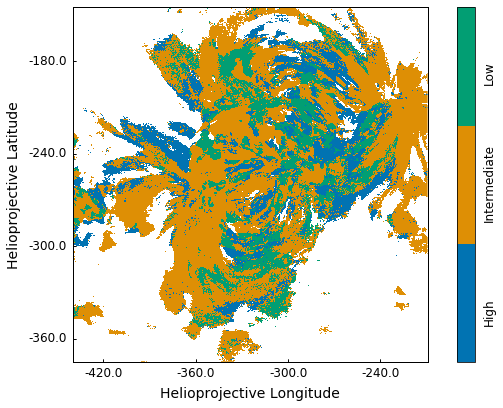

In [128]:
fig = plt.figure(figsize=get_figsize(wf=0.3))
ax = fig.gca(projection=frequency_map)
im = frequency_map.plot(
    axes=ax,title=False,
    cmap=matplotlib.colors.ListedColormap(sns.color_palette(palette='colorblind',n_colors=3,),N=3),
    vmin=-0.5,vmax=2.5)
lon,lat = ax.coords[0],ax.coords[1]
lon.set_axislabel('Helioprojective Longitude',fontsize=plt.rcParams['axes.labelsize'])
lat.set_axislabel('Helioprojective Latitude',fontsize=plt.rcParams['axes.labelsize'])
lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'])
cbar = fig.colorbar(im, ax=ax,)# ticks=[0,1,2], format=plt.FuncFormatter(lambda val, loc: ['high','intermediate','low'][val]),)
cbar.set_ticks([0,1.3,2])
cbar.ax.set_yticklabels(['High','Intermediate','Low'],rotation=90)
cbar.ax.tick_params(axis='y',which='both',length=0)
ax.grid(alpha=0)
fig.savefig('../figures/class_map.pdf')